In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

# Establecer estilo de visualización
sns.set(style="whitegrid")

# --- FASE 1: TRANSFORMACIÓN DE DATOS (Ref: PDF "13 Transformación de datos.pdf") ---
print("--- INICIANDO FASE 1: TRANSFORMACIÓN DE DATOS ---")

# 1. Cargar y transformar 'WHO_life_expectancy.csv'
print("\nCargando y limpiando datos de OMS (WHO_life_expectancy.csv)...")
try:
    df_who = pd.read_csv("data_2025/WHO_life_expectancy.csv")
    
    # Tarea clave: Extraer el valor numérico de la columna 'Value'
    # 'Value' tiene el formato "51.5 [50.5-52.6]". Queremos "51.5".
    df_who['Life_Expectancy'] = pd.to_numeric(
        df_who['Value'].str.split(' ', expand=True)[0], 
        errors='coerce'
    )
    
    # Tarea clave: Filtrar para obtener datos consistentes
    df_who_clean = df_who[
        (df_who['Indicator'] == 'Life expectancy at birth (years)') & 
        (df_who['Dim1'] == 'Both sexes')
    ].copy()
    
    # Seleccionar y renombrar columnas para la unión
    df_who_clean = df_who_clean[['Location', 'Period', 'Life_Expectancy']]
    df_who_clean.rename(columns={'Location': 'Country', 'Period': 'Year'}, inplace=True)
    
    print("Datos de OMS limpios (primeras 5 filas):")
    print(df_who_clean.head())
    print("\nInformación de datos OMS limpios:")
    df_who_clean.info()

except Exception as e:
    print(f"Error al procesar el archivo de la OMS: {e}")
    df_who_clean = pd.DataFrame() # Crear dataframe vacío para que el script no falle

# 2. Cargar y transformar 'pib2020-2025.csv'
print("\nCargando y transformando datos de PIB (pib2020-2025.csv)...")
try:
    df_pib = pd.read_csv("data_2025/pib2020-2025.csv")
    
    # Tarea clave: Transformar de formato "ancho" a "largo" (pd.melt)
    df_pib_long = df_pib.melt(
        id_vars=['Country'], 
        var_name='Year', 
        value_name='GDP'
    )
    
    # Convertir 'Year' a numérico para poder unir.
    # Coerce manejará cualquier error si 'Year' no es un número (aunque en este caso lo son).
    df_pib_long['Year'] = pd.to_numeric(df_pib_long['Year'], errors='coerce')
    
    # Manejar Nulos (NaN)
    df_pib_long.dropna(subset=['GDP', 'Year'], inplace=True)
    
    print("Datos de PIB transformados a formato largo (primeras 5 filas):")
    print(df_pib_long.head())
    print("\nInformación de datos PIB transformados:")
    df_pib_long.info()

except Exception as e:
    print(f"Error al procesar el archivo del PIB: {e}")
    df_pib_long = pd.DataFrame() # Crear dataframe vacío

# 3. Unir (Merge) los dos DataFrames
print("\nUniendo (merge) datos de PIB y Esperanza de Vida...")
if not df_who_clean.empty and not df_pib_long.empty:
    df_master = pd.merge(df_pib_long, df_who_clean, on=['Country', 'Year'])
    
    # Eliminar cualquier fila donde falte un dato clave después del merge
    df_master.dropna(subset=['GDP', 'Life_Expectancy'], inplace=True)
    
    print("DataFrame Maestro creado (primeras 5 filas):")
    print(df_master.head())
    print(f"\nForma del DataFrame Maestro: {df_master.shape}")
else:
    print("No se pudo crear el DataFrame Maestro debido a errores previos.")
    df_master = pd.DataFrame()
print("\n--- EJECUCIÓN COMPLETA ---")

--- INICIANDO FASE 1: TRANSFORMACIÓN DE DATOS ---

Cargando y limpiando datos de OMS (WHO_life_expectancy.csv)...
Datos de OMS limpios (primeras 5 filas):
                     Country  Year  Life_Expectancy
2                    Lesotho  2021             51.5
5   Central African Republic  2021             52.3
6                    Somalia  2021             54.0
8                   Eswatini  2021             54.6
18                Mozambique  2021             57.7

Información de datos OMS limpios:
<class 'pandas.core.frame.DataFrame'>
Index: 4070 entries, 2 to 23856
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          4070 non-null   object 
 1   Year             4070 non-null   int64  
 2   Life_Expectancy  4070 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 127.2+ KB

Cargando y transformando datos de PIB (pib2020-2025.csv)...
Datos de PIB transformados a formato larg



--- INICIANDO FASE 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---

Estadísticas Descriptivas (PIB y Esperanza de Vida):
                GDP  Life_Expectancy
count  3.210000e+02       321.000000
mean   3.664041e+05        71.520561
std    1.458291e+06         7.324817
min    2.220000e+02        51.500000
25%    1.222200e+04        66.100000
50%    3.820900e+04        72.600000
75%    2.105410e+05        76.800000
max    1.819080e+07        84.700000
Correlación (Ref: PDF 14)

Correlación de Pearson (PIB vs. Esperanza de Vida): 0.2138

Generando visualizaciones (Histograma y Gráfico de Dispersión)...


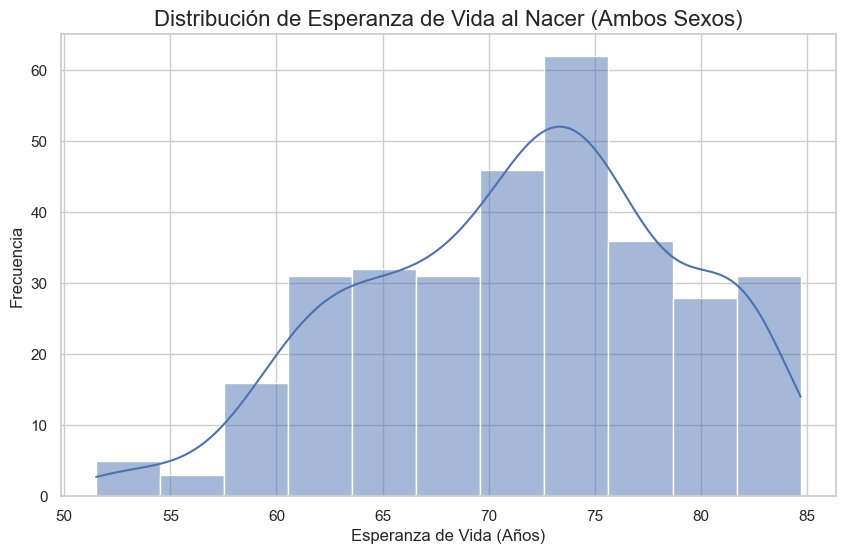

Histograma 'histograma_vida.png' guardado.


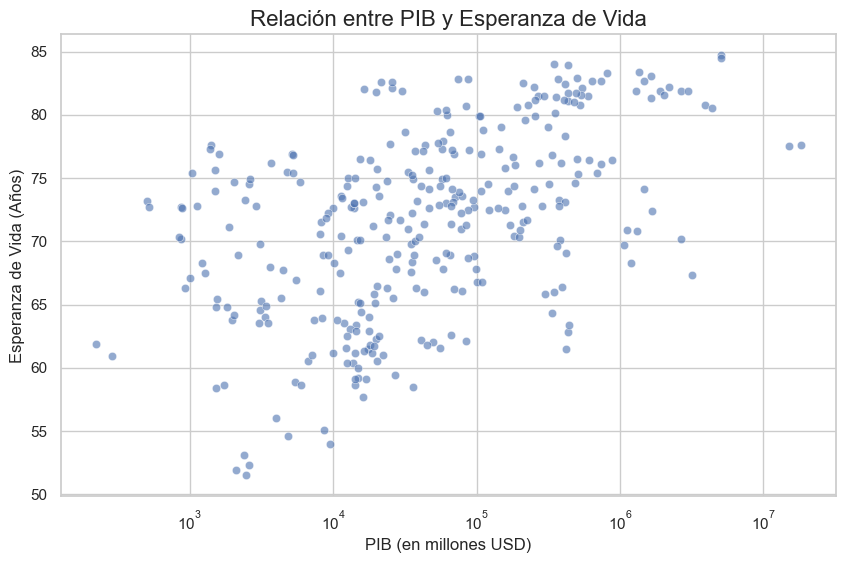

Gráfico de dispersión 'scatter_gdp_vida.png' guardado.


In [14]:
# --- FASE 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) (Ref: PDFs "14-17 Exploración de datos.pdf") ---
print("\n\n--- INICIANDO FASE 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---")
# 1. Estadísticas Descriptivas (Ref: PDF 14)
print("\nEstadísticas Descriptivas (PIB y Esperanza de Vida):")
print(df_master[['GDP', 'Life_Expectancy']].describe())
                            
print("Correlación (Ref: PDF 14)")
correlation = df_master['GDP'].corr(df_master['Life_Expectancy'])
print(f"\nCorrelación de Pearson (PIB vs. Esperanza de Vida): {correlation:.4f}")
                            
# 3. Análisis Univariado (Histograma) (Ref: PDF 15)
print("\nGenerando visualizaciones (Histograma y Gráfico de Dispersión)...")
plt.figure(figsize=(10, 6))
sns.histplot(df_master['Life_Expectancy'], kde=True)
plt.title('Distribución de Esperanza de Vida al Nacer (Ambos Sexos)', fontsize=16)
plt.xlabel('Esperanza de Vida (Años)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()
plt.savefig('histograma_vida.png')
plt.close()
print("Histograma 'histograma_vida.png' guardado.")
    
# 4. Análisis Bivariado (Scatter Plot) (Ref: PDF 16)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_master, x='GDP', y='Life_Expectancy', alpha=0.6)
plt.title('Relación entre PIB y Esperanza de Vida', fontsize=16)
plt.xlabel('PIB (en millones USD)', fontsize=12)
plt.ylabel('Esperanza de Vida (Años)', fontsize=12)
plt.xscale('log') # Usar escala logarítmica para el PIB es común por la gran dispersión
plt.show()
plt.savefig('scatter_gdp_vida.png')
plt.close()
print("Gráfico de dispersión 'scatter_gdp_vida.png' guardado.")

Tarea A: 

Regresión (Predecir Esperanza de Vida)Objetivo: Predecir el número exacto de años de esperanza de vida usando el PIB.Resultados:$MSE$: 42.25$

R^2$: -0.0038 (¡muy bajo, cercano a cero!)

Interpretación : Un $R^2$ tan bajo significa que el PIB por sí solo no explica casi nada de la variación en la esperanza de vida en este modelo lineal. Esto confirma lo que vimos en la débil correlación.Tarea B: Clasificación (Predecir "Alta" o "Baja" Esperanza de Vida)Objetivo: Clasificar si un país tiene esperanza de vida "Alta" ( $> 72.6$ años) o "Baja" ( $\le 72.6$ años) usando el PIB.Resultados

(Regresión Logística - Ref: PDF 21):Tiene una precisión (accuracy) total del 63%.Es bueno para identificar a los de esperanza de vida "Baja" (Recall = 0.94) pero muy malo para identificar a los de "Alta" (Recall = 0.31).Resultados 

(Árbol de Decisión - Ref: PDF 23):Tiene una precisión total del 63%.Es más equilibrado: identifica correctamente al 52% de la clase "Baja" y al 75% de la clase "Alta"

In [15]:
print("\n\n--- INICIANDO FASE 3: APRENDIZAJE DE MÁQUINAS (ML) ---")
    
    # --- TAREA A: REGRESIÓN (Predecir Esperanza de Vida) (Ref: PDFs 18-20) ---
print("\n--- Tarea A: Regresión Lineal (Predecir Esperanza de Vida usando PIB) ---")    
    # 1. Preparar datos
X_reg = df_master[['GDP']] # Features (variables independientes)
y_reg = df_master['Life_Expectancy'] # Target (variable dependiente)
    
    # 2. Dividir datos (Ref: PDF 19)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )
    
    # 3. Entrenar modelo
reg_model = LinearRegression()
reg_model.fit(X_train_r, y_train_r)
    
    # 4. Evaluar modelo (Ref: PDF 19)
y_pred_r = reg_model.predict(X_test_r)
mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
    
print(f"Resultados del Modelo de Regresión:")
print(f"  Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"  Coeficiente de Determinación (R^2): {r2:.4f}")
    
    # --- TAREA B: CLASIFICACIÓN (Predecir 'Alta'/'Baja' Esperanza de Vida) (Ref: PDFs 21, 23) ---
print("\n--- Tarea B: Clasificación (Predecir si la Esperanza de Vida es 'Alta' o 'Baja') ---")
    
    # 1. Crear variable objetivo categórica
median_life = df_master['Life_Expectancy'].median()
print(f"Creando variable 'High_Life' (1 si > {median_life:.2f} años, 0 si no).")
df_master['High_Life'] = (df_master['Life_Expectancy'] > median_life).astype(int)
print("Distribución de clases (0=Baja, 1=Alta):")
print(df_master['High_Life'].value_counts())
    
    # 2. Preparar datos de clasificación
X_class = df_master[['GDP']] # Features
y_class = df_master['High_Life'] # Target
    
    # 3. Dividir datos (stratify=y es importante en clasificación)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
    )
    
    # 4. Modelo 1: Regresión Logística (Ref: PDF 21)
print("\n  Resultados del Modelo: Regresión Logística")
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_c, y_train_c)
y_pred_log = log_model.predict(X_test_c)
    
print("  Reporte de Clasificación (Regresión Logística):")
print(classification_report(y_test_c, y_pred_log, target_names=['Baja (0)', 'Alta (1)']))
print("  Matriz de Confusión (Regresión Logística):")
print(confusion_matrix(y_test_c, y_pred_log))
    
    # 5. Modelo 2: Árbol de Decisión (Ref: PDF 23)
print("\n  Resultados del Modelo: Árbol de Decisión")
    # Usamos max_depth=3 para evitar overfitting (como se discute en los PDF)
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train_c, y_train_c)
y_pred_tree = tree_model.predict(X_test_c)
    
print("  Reporte de Clasificación (Árbol de Decisión):")
print(classification_report(y_test_c, y_pred_tree, target_names=['Baja (0)', 'Alta (1)']))
print("  Matriz de Confusión (Árbol de Decisión):")
print(confusion_matrix(y_test_c, y_pred_tree))



--- INICIANDO FASE 3: APRENDIZAJE DE MÁQUINAS (ML) ---

--- Tarea A: Regresión Lineal (Predecir Esperanza de Vida usando PIB) ---
Resultados del Modelo de Regresión:
  Error Cuadrático Medio (MSE): 42.2504
  Coeficiente de Determinación (R^2): -0.0038

--- Tarea B: Clasificación (Predecir si la Esperanza de Vida es 'Alta' o 'Baja') ---
Creando variable 'High_Life' (1 si > 72.60 años, 0 si no).
Distribución de clases (0=Baja, 1=Alta):
High_Life
0    164
1    157
Name: count, dtype: int64

  Resultados del Modelo: Regresión Logística
  Reporte de Clasificación (Regresión Logística):
              precision    recall  f1-score   support

    Baja (0)       0.58      0.94      0.72        33
    Alta (1)       0.83      0.31      0.45        32

    accuracy                           0.63        65
   macro avg       0.71      0.63      0.59        65
weighted avg       0.71      0.63      0.59        65

  Matriz de Confusión (Regresión Logística):
[[31  2]
 [22 10]]

  Resultados del M

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

# Establecer estilo de visualización
sns.set(style="whitegrid")

# --- FASE 1: TRANSFORMACIÓN DE DATOS (Ref: PDF "13 Transformación de datos.pdf") ---
print("--- INICIANDO FASE 1: TRANSFORMACIÓN DE DATOS ---")

# 1. Cargar y transformar 'WHO_life_expectancy.csv'
print("\nCargando y limpiando datos de OMS (WHO_life_expectancy.csv)...")
try:
    df_who = pd.read_csv("WHO_life_expectancy.csv")
    
    # Tarea clave: Extraer el valor numérico de la columna 'Value'
    # 'Value' tiene el formato "51.5 [50.5-52.6]". Queremos "51.5".
    df_who['Life_Expectancy'] = pd.to_numeric(
        df_who['Value'].str.split(' ', expand=True)[0], 
        errors='coerce'
    )
    
    # Tarea clave: Filtrar para obtener datos consistentes
    df_who_clean = df_who[
        (df_who['Indicator'] == 'Life expectancy at birth (years)') & 
        (df_who['Dim1'] == 'Both sexes')
    ].copy()
    
    # Seleccionar y renombrar columnas para la unión
    df_who_clean = df_who_clean[['Location', 'Period', 'Life_Expectancy']]
    df_who_clean.rename(columns={'Location': 'Country', 'Period': 'Year'}, inplace=True)
    
    print("Datos de OMS limpios (primeras 5 filas):")
    print(df_who_clean.head())
    print("\nInformación de datos OMS limpios:")
    df_who_clean.info()

except Exception as e:
    print(f"Error al procesar el archivo de la OMS: {e}")
    df_who_clean = pd.DataFrame() # Crear dataframe vacío para que el script no falle

# 2. Cargar y transformar 'pib2020-2025.csv'
print("\nCargando y transformando datos de PIB (pib2020-2025.csv)...")
try:
    df_pib = pd.read_csv("pib2020-2025.csv")
    
    # Tarea clave: Transformar de formato "ancho" a "largo" (pd.melt)
    df_pib_long = df_pib.melt(
        id_vars=['Country'], 
        var_name='Year', 
        value_name='GDP'
    )
    
    # Convertir 'Year' a numérico para poder unir.
    # Coerce manejará cualquier error si 'Year' no es un número (aunque en este caso lo son).
    df_pib_long['Year'] = pd.to_numeric(df_pib_long['Year'], errors='coerce')
    
    # Manejar Nulos (NaN)
    df_pib_long.dropna(subset=['GDP', 'Year'], inplace=True)
    
    print("Datos de PIB transformados a formato largo (primeras 5 filas):")
    print(df_pib_long.head())
    print("\nInformación de datos PIB transformados:")
    df_pib_long.info()

except Exception as e:
    print(f"Error al procesar el archivo del PIB: {e}")
    df_pib_long = pd.DataFrame() # Crear dataframe vacío

# 3. Unir (Merge) los dos DataFrames
print("\nUniendo (merge) datos de PIB y Esperanza de Vida...")
if not df_who_clean.empty and not df_pib_long.empty:
    df_master = pd.merge(df_pib_long, df_who_clean, on=['Country', 'Year'])
    
    # Eliminar cualquier fila donde falte un dato clave después del merge
    df_master.dropna(subset=['GDP', 'Life_Expectancy'], inplace=True)
    
    print("DataFrame Maestro creado (primeras 5 filas):")
    print(df_master.head())
    print(f"\nForma del DataFrame Maestro: {df_master.shape}")
else:
    print("No se pudo crear el DataFrame Maestro debido a errores previos.")
    df_master = pd.DataFrame()

# --- FASE 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) (Ref: PDFs "14-17 Exploración de datos.pdf") ---
if not df_master.empty:
    print("\n\n--- INICIANDO FASE 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---")
    
    # 1. Estadísticas Descriptivas (Ref: PDF 14)
    print("\nEstadísticas Descriptivas (PIB y Esperanza de Vida):")
    print(df_master[['GDP', 'Life_Expectancy']].describe())
    
    # 2. Correlación (Ref: PDF 14)
    correlation = df_master['GDP'].corr(df_master['Life_Expectancy'])
    print(f"\nCorrelación de Pearson (PIB vs. Esperanza de Vida): {correlation:.4f}")
    
    # 3. Análisis Univariado (Histograma) (Ref: PDF 15)
    print("\nGenerando visualizaciones (Histograma y Gráfico de Dispersión)...")
    plt.figure(figsize=(10, 6))
    sns.histplot(df_master['Life_Expectancy'], kde=True)
    plt.title('Distribución de Esperanza de Vida al Nacer (Ambos Sexos)', fontsize=16)
    plt.xlabel('Esperanza de Vida (Años)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.savefig('histograma_vida.png')
    plt.close()
    print("Histograma 'histograma_vida.png' guardado.")
    
    # 4. Análisis Bivariado (Scatter Plot) (Ref: PDF 16)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_master, x='GDP', y='Life_Expectancy', alpha=0.6)
    plt.title('Relación entre PIB y Esperanza de Vida', fontsize=16)
    plt.xlabel('PIB (en millones USD)', fontsize=12)
    plt.ylabel('Esperanza de Vida (Años)', fontsize=12)
    plt.xscale('log') # Usar escala logarítmica para el PIB es común por la gran dispersión
    plt.savefig('scatter_gdp_vida.png')
    plt.close()
    print("Gráfico de dispersión 'scatter_gdp_vida.png' guardado.")

else:
    print("\nOmitiendo FASE 2 y 3 porque el DataFrame Maestro está vacío.")

# --- FASE 3: APRENDIZAJE DE MÁQUINAS (ML) (Ref: PDFs "18-23 Aprendizaje de máquinas.pdf") ---
if not df_master.empty:
    print("\n\n--- INICIANDO FASE 3: APRENDIZAJE DE MÁQUINAS (ML) ---")
    
    # --- TAREA A: REGRESIÓN (Predecir Esperanza de Vida) (Ref: PDFs 18-20) ---
    print("\n--- Tarea A: Regresión Lineal (Predecir Esperanza de Vida usando PIB) ---")
    
    # 1. Preparar datos
    X_reg = df_master[['GDP']] # Features (variables independientes)
    y_reg = df_master['Life_Expectancy'] # Target (variable dependiente)
    
    # 2. Dividir datos (Ref: PDF 19)
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )
    
    # 3. Entrenar modelo
    reg_model = LinearRegression()
    reg_model.fit(X_train_r, y_train_r)
    
    # 4. Evaluar modelo (Ref: PDF 19)
    y_pred_r = reg_model.predict(X_test_r)
    mse = mean_squared_error(y_test_r, y_pred_r)
    r2 = r2_score(y_test_r, y_pred_r)
    
    print(f"Resultados del Modelo de Regresión:")
    print(f"  Error Cuadrático Medio (MSE): {mse:.4f}")
    print(f"  Coeficiente de Determinación (R^2): {r2:.4f}")
    
    # --- TAREA B: CLASIFICACIÓN (Predecir 'Alta'/'Baja' Esperanza de Vida) (Ref: PDFs 21, 23) ---
    print("\n--- Tarea B: Clasificación (Predecir si la Esperanza de Vida es 'Alta' o 'Baja') ---")
    
    # 1. Crear variable objetivo categórica
    median_life = df_master['Life_Expectancy'].median()
    print(f"Creando variable 'High_Life' (1 si > {median_life:.2f} años, 0 si no).")
    df_master['High_Life'] = (df_master['Life_Expectancy'] > median_life).astype(int)
    print("Distribución de clases (0=Baja, 1=Alta):")
    print(df_master['High_Life'].value_counts())
    
    # 2. Preparar datos de clasificación
    X_class = df_master[['GDP']] # Features
    y_class = df_master['High_Life'] # Target
    
    # 3. Dividir datos (stratify=y es importante en clasificación)
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
    )
    
    # 4. Modelo 1: Regresión Logística (Ref: PDF 21)
    print("\n  Resultados del Modelo: Regresión Logística")
    log_model = LogisticRegression(random_state=42)
    log_model.fit(X_train_c, y_train_c)
    y_pred_log = log_model.predict(X_test_c)
    
    print("  Reporte de Clasificación (Regresión Logística):")
    print(classification_report(y_test_c, y_pred_log, target_names=['Baja (0)', 'Alta (1)']))
    print("  Matriz de Confusión (Regresión Logística):")
    print(confusion_matrix(y_test_c, y_pred_log))
    
    # 5. Modelo 2: Árbol de Decisión (Ref: PDF 23)
    print("\n  Resultados del Modelo: Árbol de Decisión")
    # Usamos max_depth=3 para evitar overfitting (como se discute en los PDF)
    tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_model.fit(X_train_c, y_train_c)
    y_pred_tree = tree_model.predict(X_test_c)
    
    print("  Reporte de Clasificación (Árbol de Decisión):")
    print(classification_report(y_test_c, y_pred_tree, target_names=['Baja (0)', 'Alta (1)']))
    print("  Matriz de Confusión (Árbol de Decisión):")
    print(confusion_matrix(y_test_c, y_pred_tree))

print("\n--- EJECUCIÓN COMPLETA ---")

--- INICIANDO FASE 1: TRANSFORMACIÓN DE DATOS ---

Cargando y limpiando datos de OMS (WHO_life_expectancy.csv)...
Error al procesar el archivo de la OMS: [Errno 2] No such file or directory: 'WHO_life_expectancy.csv'

Cargando y transformando datos de PIB (pib2020-2025.csv)...
Error al procesar el archivo del PIB: [Errno 2] No such file or directory: 'pib2020-2025.csv'

Uniendo (merge) datos de PIB y Esperanza de Vida...
No se pudo crear el DataFrame Maestro debido a errores previos.

Omitiendo FASE 2 y 3 porque el DataFrame Maestro está vacío.

--- EJECUCIÓN COMPLETA ---
